In [1]:
import numpy as np


#加载数据
def load_data():
    #可分不可分都可以处理
    with open('线性不可分数据集.txt') as fr:
        lines = fr.readlines()

    x = np.ones((len(lines), 2), dtype=float)
    y = np.empty(len(lines), dtype=float)

    for i in range(len(lines)):
        line = lines[i].strip().split(',')
        x[i] = line[:2]
        y[i] = line[2]

    y = y.astype(np.int)

    return x, y


x, y = load_data()
x[:5], y[:5]

(array([[-1.06595, -2.74223],
        [-0.87436, -1.91486],
        [ 1.39905, -1.28352],
        [ 0.18064, -2.87754],
        [-0.22919, -1.86742]]),
 array([1, 1, 1, 1, 1]))

In [2]:
#常量
N, M = x.shape

w = np.empty(M)
w.fill(1 / M)
b = 0.0

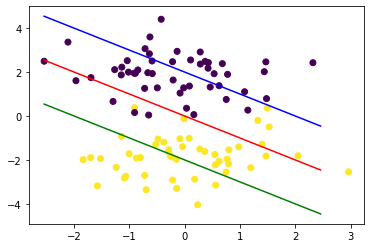

In [3]:
import matplotlib.pyplot as plt


#把线画出来,线就是wx + b = 0
def draw():
    X = np.arange(x[:, 0].min(), x[:, 0].max(), 1)
    Y = np.empty([len(X)])

    for i in range(len(X)):
        Y[i] = (-w[0] * X[i] - b) / w[1]
    plt.plot(X, Y, c='red')

    for i in range(len(X)):
        Y[i] = (1 - w[0] * X[i] - b) / w[1]
    plt.plot(X, Y, c='blue')

    for i in range(len(X)):
        Y[i] = (-1 - w[0] * X[i] - b) / w[1]
    plt.plot(X, Y, c='green')

    plt.scatter(x[:, 0], x[:, 1], c=y)

    plt.show()


draw()

In [4]:
def predict(x):
    return w.dot(x) + b


predict(x[0])

-1.90409

In [5]:
#函数距离,缺点是w和b同时成比例变化时,它也会变化
def functional_margin(x, y):
    return y * w.dot(x) + b


#几何距离,w和b成比例变化时,对它没有影响
def geometric_marginn(x, y):
    l2_w = (w**2).sum()**0.5
    return functional_margin(x, y) / l2_w


functional_margin(x[0], y[0]), geometric_marginn(x[0], y[0])

(-1.90409, -2.6927899019789865)

In [6]:
#最小函数距离
def min_functional_margin():
    _min = np.inf
    for i in range(N):
        temp = functional_margin(x[i], y[i])
        if temp < 0:
            continue
        if temp < _min:
            _min = temp
    return _min


#最小几何距离
def min_geometric_marginn():
    l2_w = (w**2).sum()**0.5
    return min_functional_margin() / l2_w


min_functional_margin(), min_geometric_marginn()

(0.023865000000000025, 0.03375020666603395)

In [7]:
#现在的问题就是要max 最小几何距离 对每一个xy满足 几何距离 >= 最小几何距离
#写成函数就是 max min_geometric_marginn st. geometric_marginn(x,y) >= min_geometric_marginn

#试一下用梯度下降的方法来找到这个解

#合页损失函数
def get_loss():
    #loss分两部分,第1部分是w越大loss越大,第2部分是预测错误的loss
    lam = 0.2  #平衡两部分loss的变量
    l2_w = (w**2).sum()  #w越大loss越大

    loss = 0
    for i in range(N):
        pred = y[i] * (w.dot(x[i]) + b)
        pred = 1 - pred  #如果分类正确,那至少要正确到1以上,即使计算结果是0.9,也认为是错误
        relu = pred if pred > 0 else 0  #本来正数是预测正确,上面因为用1减了,所以变号了,现在是负数才是预测正确
        loss += relu
    return loss + lam * l2_w


get_loss()

186.34919000000005

In [8]:
#我发明的暴力求梯度的方法.
def get_gradient():
    global w
    global b

    #这个变量就是增量了
    upsilon = 1e-5

    #先算出给增量前的loss
    loss = get_loss()

    #求w梯度
    grad_w = np.empty(M)
    for i in range(M):
        w[i] += upsilon
        loss2 = get_loss()
        w[i] -= upsilon
        grad_w[i] = (loss2 - loss) / upsilon

    #求b梯度
    b += upsilon
    loss2 = get_loss()
    b -= upsilon
    grad_b = (loss2 - loss) / upsilon

    return grad_w, grad_b


get_gradient()

(array([-12.05341801, 184.95180199]), -5.684341886080801e-09)

0 152.0036068893805
200 9.183026404654
400 8.929522873248773
600 8.74566584792982
800 8.594796294245398
1000 8.580817045414612
1200 8.568907394232566
1400 8.559163671955792


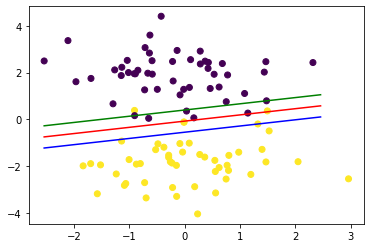

In [9]:
for epoch in range(1500):
    grad_w, grad_b = get_gradient()
    w -= grad_w * 1e-3
    b -= grad_b * 1e-3

    if epoch % 200 == 0:
        print(epoch, get_loss())

draw()